# Поиск изображений по запросу

Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

В файле `###.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `###` содержатся изображения для тренировки модели.

В файле `###.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `###.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `###.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `###` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

### Загрузка данных

In [ ]:
# Standard library imports
import os
from pathlib import Path
from collections import Counter
import random

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# NLP imports
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel

# Machine Learning imports
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

# Deep Learning imports
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Gradient Boosting import
from lightgbm import LGBMRegressor

# Constants
RANDOM_STATE = 42

In [ ]:
# Загрузка данных
!wget -q https://###.zip
!unzip -q ###.zip

# Указываем путь с помощью Path
DATA_PATH = Path('/content/to_upload')

replace to_upload/test_images.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# Пути к папкам с изображениями
train_image_dir = DATA_PATH / 'train_images'
test_image_dir = DATA_PATH / 'test_images'

# Загрузка данных
test_queries = pd.read_csv(DATA_PATH / "###.csv", sep='|', index_col=0)
test_images = pd.read_csv(DATA_PATH / "###.csv")
train_dataset = pd.read_csv(DATA_PATH / "###.csv")

crowd_annotations = pd.read_csv(
    DATA_PATH / "###.tsv",
    sep='\t', header=None,
    names=['image', 'query_id', 'rate_confirmed', 'count_confirmed', 'count_not_confirmed']
)

expert_annotations = pd.read_csv(
    DATA_PATH / "###.tsv",
    sep='\t', header=None,
    names=['image', 'query_id', 'exp_1', 'exp_2', 'exp_3']
)

In [ ]:
# Функция для получения общей информации о датасете
def get_info(data):
    display(data.head())
    print('')
    data.info()
    print('')
    display(data.describe().T)
    print('')
    print('Количество явных дубликатов:', data.duplicated().sum())
    print('Количество пропусков:\n', data.isna().sum())

In [ ]:
get_info(train_dataset)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB



count unique                                                top  \
image       5822   1000                           754852108_72f80d421f.jpg   
query_id    5822    977                        2600867924_cd502fc911.jpg#2   
query_text  5822    977  Two dogs , one brown and white and one black a...   

           freq  
image        10  
query_id     34  
query_text   34


Количество явных дубликатов: 0
Количество пропусков:
 image         0
query_id      0
query_text    0
dtype: int64


- Размер: 5822 записей.
- Колонки:
  - `image` — имя файла изображения (1000 уникальных).
  - `query_id` — идентификатор текстового описания, формат похож на `<image_name>#<индекс>`, всего 977 уникальных.
  - `query_text` — текст описания, всего 977 уникальных значений.
- Нет пропусков и явных дубликатов.
- Самый частый image встречается 10 раз.
- Самый частый query_id встречается 34 раза.
- Самый частый текст query_text встречается 34 раза.

In [ ]:
get_info(test_queries)

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB



count unique                                                top  \
query_id     500    500                         989851184_9ef368e520.jpg#4   
query_text   500    500  The black dog has a toy in its mouth and a per...   
image        500    100                          1177994172_10d143cb8d.jpg   

           freq  
query_id      1  
query_text    1  
image         5


Количество явных дубликатов: 0
Количество пропусков:
 query_id      0
query_text    0
image         0
dtype: int64


- В датасете 500 записей.
- Каждая запись содержит:
  - `query_id` — уникальный идентификатор в формате "название_файла.jpg#число".
  - `query_text` — текст запроса/описания изображения.
  - `image` — имя файла с изображением.
- `query_id` содержит 500 уникальных значений (все уникальны).
- `query_text` — также 500 уникальных текстов (т.е. повторяющихся описаний нет).
- `image` — всего 100 уникальных изображений, каждое изображение встречается в среднем 5 раз (т.к. всего 500 записей и 100 уникальных изображений).
- Явных дубликатов и пропусков в данных нет.

На одно изображение приходится по нескольку разных текстовых описаний.



In [ ]:
get_info(test_images)

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes



count unique                        top freq
image   100    100  3356748019_2251399314.jpg    1


Количество явных дубликатов: 0
Количество пропусков:
 image    0
dtype: int64


- Таблица с одной колонкой `image`.
- Всего 100 строк.
- Все значения в колонке `image` непустые.
- Уникальных значений в `image` — ровно 100, то есть все записи уникальны.
- Явных дубликатов нет, пропусков тоже нет.
- Максимальная частота любого значения — 1 (каждое изображение встречается только один раз).

In [ ]:
get_info(crowd_annotations)

image                     query_id  rate_confirmed  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2             1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2             0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2             0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2             0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2             0.0   

   count_confirmed  count_not_confirmed  
0                3                    0  
1                0                    3  
2                0                    3  
3                0                    3  
4                0                    3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                47830 non-null  object 
 1   query_id             47830 non-null  object 
 2   rate_confirmed       47830 non-null  float64
 3   count_confirmed      47830 non-null  int64  
 4   count_not_confirmed  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB



count      mean       std  min  25%  50%  75%  max
rate_confirmed       47830.0  0.068786  0.207532  0.0  0.0  0.0  0.0  1.0
count_confirmed      47830.0  0.208488  0.628898  0.0  0.0  0.0  0.0  5.0
count_not_confirmed  47830.0  2.820155  0.656676  0.0  3.0  3.0  3.0  6.0


Количество явных дубликатов: 0
Количество пропусков:
 image                  0
query_id               0
rate_confirmed         0
count_confirmed        0
count_not_confirmed    0
dtype: int64


Таблица 47,830 строк и 5 колонок:
- Отсутствие пропущенных значений
- Дубликатов нет
- `rate_confirmed`: среднее около 0.07, а медиана, 25 и 75 процентили равны 0 — значит большинство записей имеют rate_confirmed = 0. Максимум 1.0 показывает, что некоторые пары явно подтверждены, но их меньшинство.
- `count_confirmed` также в основном 0 — очень мало подтверждений.
- `count_not_confirmed` в основном 3, что скорее всего — минимальное число «отрицательных» голосов или проверок.





In [ ]:
crowd_annotations['rate_confirmed'].value_counts()

rate_confirmed
0.000000    41970
0.333333     3000
0.666667     1360
1.000000     1323
0.250000       96
0.500000       27
0.200000       22
0.750000        9
0.600000        8
0.400000        8
0.800000        4
0.166667        3
Name: count, dtype: int64

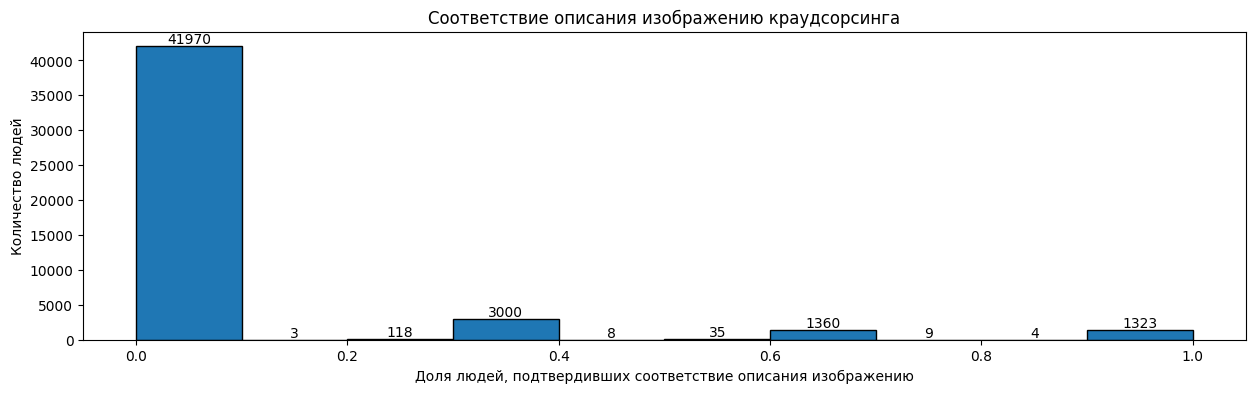

In [ ]:
ax = crowd_annotations['rate_confirmed'].plot.hist(
    bins=10,
    title="Соответствие описания изображению краудсорсинга",
    figsize=(15,4),
    edgecolor='black'
)
ax.set_ylabel('Количество людей')
ax.set_xlabel('Доля людей, подтвердивших соответствие описания изображению')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

41,970 записей (87.7%) имеют `rate_confirmed` = 0.0, что означает полное отсутствие подтверждения соответствия между изображением и текстовым описанием. Только 1,323 записи (2.8%) имеют `rate_confirmed` = 1.0 (полное подтверждение).Частичные подтверждения составляют менее 10% данных.

In [ ]:
print(f"Количество уникальных изображений в crowd_annotations: {crowd_annotations['image'].nunique()}")
print(f"Количество уникальных описаний в crowd_annotations: {crowd_annotations['query_id'].nunique()}")

Количество уникальных изображений в crowd_annotations: 1000
Количество уникальных описаний в crowd_annotations: 1000


In [ ]:
print(f"Количество уникальных изображений в crowd_annotations с rate_confirmed=1: {crowd_annotations.query('rate_confirmed==1')['image'].nunique()}")

Количество уникальных изображений в crowd_annotations с rate_confirmed=1: 713


In [ ]:
mask = crowd_annotations['image'] == crowd_annotations['query_id'].str.split('#').str[0]
matching_rows = crowd_annotations[mask]

result = len(matching_rows)
print(f"Количество изображений в crowd_annotations, совпадающих с их описанием: {result}")

Количество изображений в crowd_annotations, совпадающих с их описанием: 721


In [ ]:
get_info(expert_annotations)

image                     query_id  exp_1  exp_2  exp_3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1      1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1      2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1      2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2      2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1      2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB



count      mean       std  min  25%  50%  75%  max
exp_1  5822.0  1.436620  0.787084  1.0  1.0  1.0  2.0  4.0
exp_2  5822.0  1.624356  0.856222  1.0  1.0  1.0  2.0  4.0
exp_3  5822.0  1.881999  0.904087  1.0  1.0  2.0  2.0  4.0


Количество явных дубликатов: 0
Количество пропусков:
 image       0
query_id    0
exp_1       0
exp_2       0
exp_3       0
dtype: int64


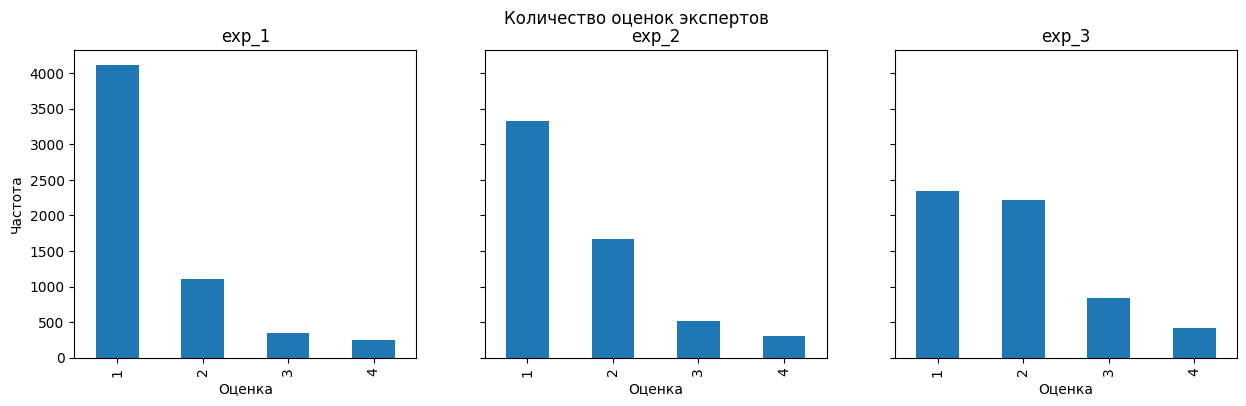

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)

for i, exp in enumerate(['exp_1', 'exp_2', 'exp_3']):
    expert_annotations[exp].value_counts().sort_index().plot(kind='bar', ax=axes[i], title=exp)
    axes[i].set_xlabel('Оценка')
    axes[i].set_ylabel('Частота' if i == 0 else '')

plt.suptitle('Количество оценок экспертов')
plt.show()

- В таблице 5822 записи с 5 колонками
- Пропусков в данных не обнаружено
- Явных дубликатов нет

**Сравнение экспертов**:
   - exp_3 в среднем ставит более высокие оценки (mean=1.88)
   - exp_1 самый строгий (mean=1.44)
   - Все эксперты чаще ставят 1 или 2, чем 3 или 4

**Качество аннотаций**:
   - Большинство описаний получают низкие оценки
   - Лишь немногие достигают оценки 3-4
   - Возможная причина: плохое качество исходных описаний



In [ ]:
print(f"Количество уникальных изображений в expert_annotations: {expert_annotations['image'].nunique()}")
print(f"Количество уникальных описаний в expert_annotations: {expert_annotations['query_id'].nunique()}")

Количество уникальных изображений в expert_annotations: 1000
Количество уникальных описаний в expert_annotations: 977


In [ ]:
perfect_matches = expert_annotations[
    (expert_annotations['exp_1'] == 4) &
    (expert_annotations['exp_2'] == 4) &
    (expert_annotations['exp_3'] == 4)
]
print(f"\nКоличество изображений с максимальной оценкой всех экспертов: {len(perfect_matches)}")


Количество изображений с максимальной оценкой всех экспертов: 247


In [ ]:
print(f"Количество уникальных изображений с максимальной оценкой всех экспертов: {perfect_matches['image'].nunique()}")

Количество уникальных изображений с максимальной оценкой всех экспертов: 214


In [ ]:
mask = expert_annotations['image'] == expert_annotations['query_id'].str.split('#').str[0]
matching_rows = expert_annotations[mask]

result = len(matching_rows)
print(f"Количество изображений в expert_annotations, совпадающих с их описанием: {result}")

Количество изображений в expert_annotations, совпадающих с их описанием: 158


Посмотрим на изображения из `images_train` и `images_test`.


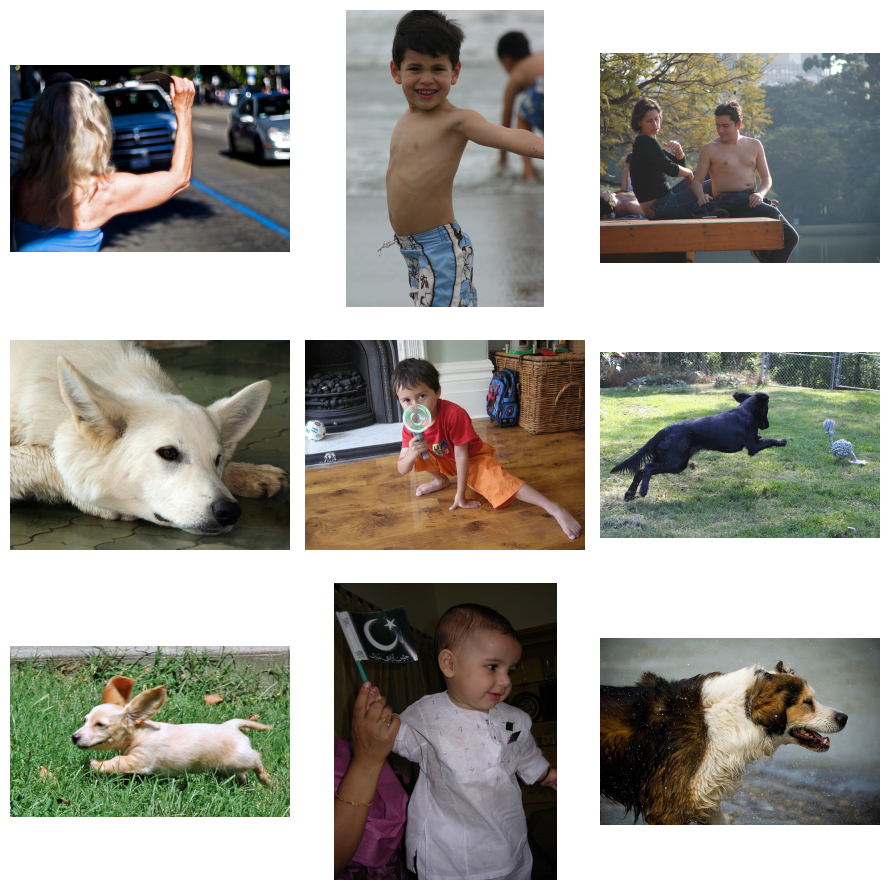

In [ ]:
images_train = [Image.open(p) for p in sorted(train_image_dir.glob('*'))[:9]]

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for img, ax in zip(images_train, axes.flat):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

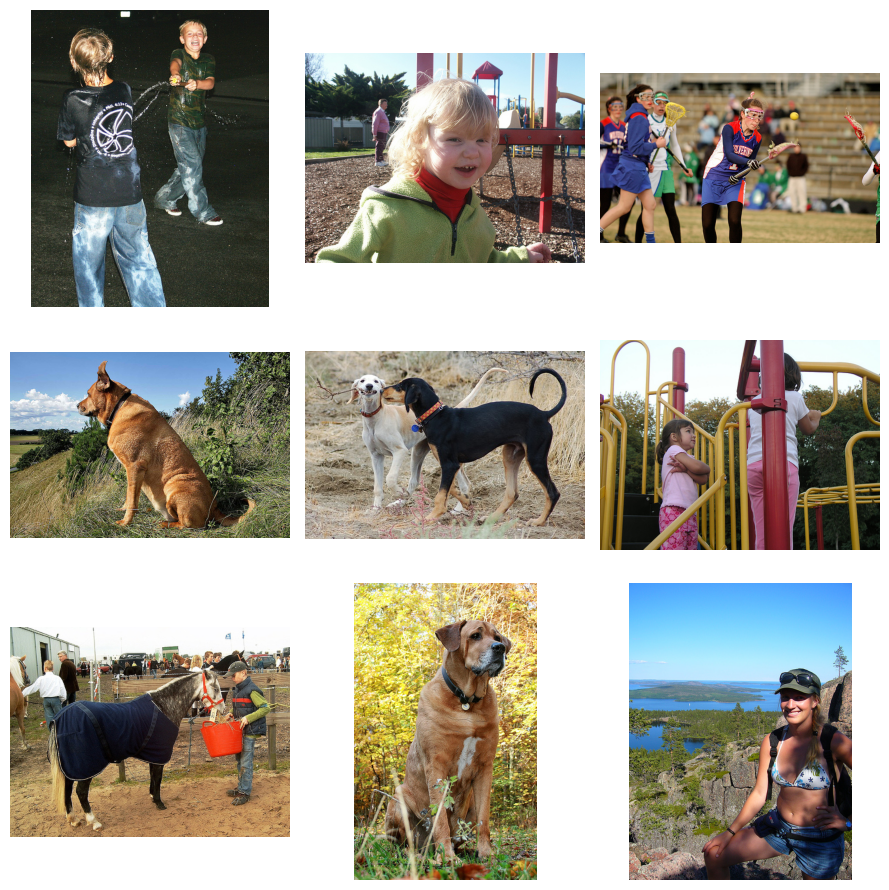

In [ ]:
paths = sorted(p for p in test_image_dir.glob('*.jpg'))[:9]
images_test = [Image.open(p) for p in paths]

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for im, ax in zip(images_test, axes.flat):
    ax.imshow(im)
    ax.axis('off')
plt.tight_layout()
plt.show()

### Агрегация оценок

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи мы должны эти оценки агрегировать — превратить в одну.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:
1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

Для построения модели выберем только оценки экспертов, т.к. в `crowd_annotations` из 1323 записей с `rate_confirmed` = 1.0 только 713 изображений являются уникальными и 721 изображений совпадают с их описанием. Это достаточно низкое качество данных.

Выполним агрегацию оценок от трех экспертов (`exp_1`, `exp_2`, `exp_3`) в единый рейтинг, используя два подхода:

1. **Мажоритарное голосование**  
   Если как минимум два эксперта поставили одинаковую оценку, эта оценка выбирается как итоговая.

2. **Среднее значение**  
   Если все три оценки разные, вычисляется среднее арифметическое.

Затем агрегированные оценки (в шкале 1-4) нормализуем в диапазон `[0, 1]`.


In [ ]:
# Агрегация оценок: мажоритарное голосование или среднее
def aggregate_ratings(row):
    ratings = [row['exp_1'], row['exp_2'], row['exp_3']]
    # Проверяем наличие оценки ≥2 экспертов
    for rating in ratings:
        if ratings.count(rating) >= 2:
            return rating
    # Если все оценки разные, возвращаем среднее
    return sum(ratings) / 3

# Применяем агрегацию
expert_annotations['aggregated_rating'] = expert_annotations.apply(aggregate_ratings, axis=1)

# Нормализация в [0, 1] (шкала 1-4)
expert_annotations['probability'] = (expert_annotations['aggregated_rating'] - 1) / 3
expert_annotations = expert_annotations.drop(columns=['exp_1', 'exp_2', 'exp_3', 'aggregated_rating'])

In [ ]:
train_dataset = pd.merge(
    train_dataset,
    expert_annotations,
    on=['image', 'query_id'],
    how='inner'
)

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5822 non-null   object 
 1   query_id     5822 non-null   object 
 2   query_text   5822 non-null   object 
 3   probability  5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 182.1+ KB


### Вывод

1. Данные загружены
2. В датасетах нет пропусков и дубликатов.
3. `train_dataset`
  - Размер: 5822 записей.
  - Колонки:
    - `image` — имя файла изображения (1000 уникальных).
    - `query_id` — идентификатор текстового описания, формат похож на `<image_name>#<индекс>`, всего 977 уникальных.
    - `query_text` — текст описания, всего 977 уникальных значений.
  - Нет пропусков и явных дубликатов.
  - Самый частый image встречается 10 раз.
  - Самый частый query_id встречается 34 раза.
  - Самый частый текст query_text встречается 34 раза.

  `test_queries`
  - В датасете 500 записей.
  - Каждая запись содержит:
    - `query_id` — уникальный идентификатор в формате "название_файла.jpg#число".
    - `query_text` — текст запроса/описания изображения.
    - `image` — имя файла с изображением.
  - `query_id` содержит 500 уникальных значений (все уникальны).
  - `query_text` — также 500 уникальных текстов (т.е. повторяющихся описаний нет).
  - `image` — всего 100 уникальных изображений, каждое изображение встречается в среднем 5 раз (т.к. всего 500 записей и 100 уникальных изображений).
  - Явных дубликатов и пропусков в данных нет.
  На одно изображение приходится по нескольку разных текстовых описаний.

  `test_images`
  - Таблица с одной колонкой `image`.
  - Всего 100 строк.
  - Все значения в колонке `image` непустые.
  - Уникальных значений в `image` — ровно 100, то есть все записи уникальны.
  - Явных дубликатов нет, пропусков тоже нет.
  - Максимальная частота любого значения — 1 (каждое изображение встречается только один раз).

  `crowd_annotations`
  - Таблица 47,830 строк и 5 колонок:
  - Отсутствие пропущенных значений
  - Дубликатов нет
  - `rate_confirmed`: среднее около 0.07, а медиана, 25 и 75 процентили равны 0 — значит большинство записей имеют rate_confirmed = 0. Максимум 1.0 показывает, что некоторые пары явно подтверждены, но их меньшинство.
  - `count_confirmed` также в основном 0 — очень мало подтверждений.
  - `count_not_confirmed` в основном 3, что скорее всего — минимальное число «отрицательных» голосов или проверок.
  - 41,970 записей (87.7%) имеют `rate_confirmed` = 0.0, что означает полное отсутствие подтверждения соответствия между изображением и текстовым описанием. Только 1,323 записи (2.8%) имеют `rate_confirmed` = 1.0 (полное подтверждение).Частичные подтверждения составляют менее 10% данных.
  - Количество уникальных изображений в crowd_annotations: 1000
  - Количество уникальных описаний в crowd_annotations: 1000
  - Количество уникальных изображений в crowd_annotations с rate_confirmed=1: 713
  - Количество изображений в crowd_annotations, совпадающих с их описанием: 721

  `expert_annotations`
  - В таблице 5822 записи с 5 колонками
  - Пропусков в данных не обнаружено
  - Явных дубликатов нет
  - exp_3 в среднем ставит более высокие оценки (mean=1.88)
  - exp_1 самый строгий (mean=1.44)
  - Все эксперты чаще ставят 1 или 2, чем 3 или 4
  - Большинство описаний получают низкие оценки
  - Лишь немногие достигают оценки 3-4, возможная причина: плохое качество исходных описаний
  - Количество уникальных изображений в expert_annotations: 1000
  - Количество уникальных описаний в expert_annotations: 977
  - Количество изображений с максимальной оценкой всех экспертов: 247
  - Количество уникальных изображений с максимальной оценкой всех экспертов: 214
  - Количество изображений в expert_annotations, совпадающих с их описанием: 158
4. Для построения модели выбрали только оценки экспертов, т.к. в `crowd_annotations` из 1323 записей с `rate_confirmed` = 1.0 только 713 изображений являются уникальными и 721 изображений совпадают с их описанием. Выполнили агрегацию оценок от трех экспертов в единый рейтинг

## 2. Проверка данных

В некоторых странах, где работает наша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


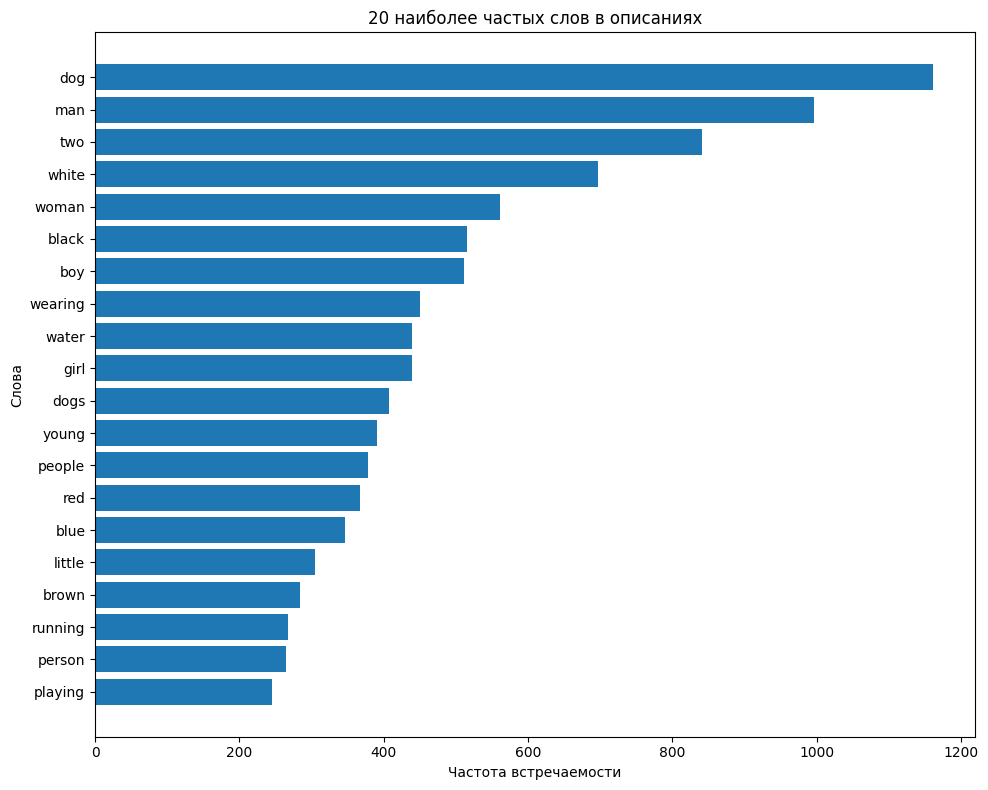

In [ ]:

nltk.download('stopwords')
sw = set(stopwords.words('english'))

words = [w.lower() for text in train_dataset['query_text']
         for w in text.split() if w.lower() not in sw and len(w) > 2]

plt.figure(figsize=(10, 8))
plt.barh(*zip(*Counter(words).most_common(20)[::-1]))
plt.title('20 наиболее частых слов в описаниях')
plt.xlabel('Частота встречаемости')
plt.ylabel('Слова')
plt.tight_layout()
plt.show()

In [ ]:
print("\nВсе уникальные слова (в строку):")
print(", ".join(sorted(set(words))))


Все уникальные слова (в строку):
across, action, actor, adult, adults, aerial, aerodynamically, african, aged, ahead, aims, air, airborne, airplane, albert, alert, ally, almost, alone, along, alongside, among, ampitheater, animal, another, appear, apple, approaches, approaching, area, arizona, arm, armbands, arms, around, art, artist, arts, asian, asleep, assist, attached, attempting, attempts, attentively, attire, atv, audience, avoid, away, awning, babies, baby, back, backdrop, background, backpack, backpacks, backs, backset, backstroke, backwards, backyard, bag, bagpipe, balances, balancing, bale, ball, balls, band, bank, bar, bare, barrels, barren, barrette, barrier, bars, base, baseball, baseman, basketball, basset, bat, bathing, bay, beach, beaded, bear, beard, bears, bed, bee, begins, behind, beige, bench, benches, bend, bends, beneath, beside, bicycle, bicycles, big, bike, biker, bikes, bikini, binoculars, bird, birds, birthday, bites, biting, black, black-rimmed, blanket, blo

In [ ]:
filter_words = {'baby', 'babies', 'child', 'children', 'girl', 'girls', 'boy', 'boys',
                'kid', 'kiddie', 'kids', 'teenage', 'teenagers', 'toddler', 'toddlers',
                'young', 'youth', 'youths'}

In [ ]:
# Создаем regex-паттерн для поиска запрещенных слов
pattern = r'\b(' + '|'.join(filter_words) + r')\b'

# 1. Находим все строки, где query_text содержит запрещённые слова
rows_with_bad_words = train_dataset[
    train_dataset['query_text'].str.lower().str.contains(pattern, regex=True, na=False)
]

# 2. Среди этих строк берем часть query_id (до символа #)
query_id_parts = rows_with_bad_words['query_id'].str.split('#').str[0]

# 3. Находим image, которые совпадают с этой частью query_id
bad_images = rows_with_bad_words[
    rows_with_bad_words['image'].isin(query_id_parts)
]['image'].unique()

# 4. Удаляем все строки с этими image из датасета
train_dataset = train_dataset[
    ~train_dataset['image'].isin(bad_images)
].reset_index(drop=True)

/tmp/ipython-input-28-1282487924.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  train_dataset['query_text'].str.lower().str.contains(pattern, regex=True, na=False)


In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4207 entries, 0 to 4206
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        4207 non-null   object 
 1   query_id     4207 non-null   object 
 2   query_text   4207 non-null   object 
 3   probability  4207 non-null   float64
dtypes: float64(1), object(3)
memory usage: 131.6+ KB


In [ ]:
print(f"Количество уникальных изображений после удаления запрещенных: {train_dataset['image'].nunique()}")

Количество уникальных изображений после удаления запрещенных: 736


### Вывод

- Создан список, содержащий связанные с детьми слова
- Удалены изображения, описания которых попали под блокировку
- Количество записей в `train_dataset` после удаления запрещенных: 4207
- Количество уникальных изображений после удаления запрещенных: 736

## 3. Векторизация изображений

Перейдём к векторизации изображений.

In [ ]:
# Загрузка предобученной модели ResNet50
model_image = resnet50(pretrained=True)
model_image.eval()  # режим оценки

# Убираем последний полносвязный слой для извлечения признаков
model_image.fc = torch.nn.Identity()

# Трансформации изображения
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def image_to_vector(img_path):
    """Функция для преобразования изображения в вектор признаков"""
    image = Image.open(img_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model_image(img_tensor)
    return features.squeeze().numpy()

# Предполагаем, что train_dataset - это DataFrame с колонкой 'image'
# Создаем список уникальных изображений из train_dataset
unique_images = train_dataset['image'].unique()

vectors = []  # здесь будем хранить векторы для всех изображений
image_names = []  # список имён файлов

for image_name in unique_images:
    image_path = os.path.join(train_image_dir, image_name)
    if os.path.exists(image_path):  # проверяем, что файл существует
        vector = image_to_vector(image_path)
        vectors.append(vector)
        image_names.append(image_name)

# Преобразуем в numpy массив
vectors_array = np.vstack(vectors)  # матрица shape=(число_изображений, 2048)
print(f'Обработано {len(vectors)} изображений.')
print(f'Форма массива векторов: {vectors_array.shape}')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Обработано 736 изображений.
Форма массива векторов: (736, 2048)


### Вывод

- Выполнена векторизация изображений
- Обработано 736 изображений.
- Форма массива векторов: (736, 2048)

## 4. Векторизация текстов

Следующий этап — векторизация текстов.


In [ ]:
print(f"Количество уникальных текстов: {train_dataset['query_text'].nunique()}")

Количество уникальных текстов: 948


In [ ]:
# Загружаем модель и токенизатор (можно заменить на более легкие, например, 'distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_text = BertModel.from_pretrained('bert-base-uncased')

# Уникальные тексты (чтобы не векторизовать одно и то же несколько раз)
unique_texts = train_dataset['query_text'].unique()

# Векторизация всех уникальных текстов
text_vectors = {}
for text in unique_texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model_text(**inputs)
    # Усредняем выходы последнего слоя (можно использовать [CLS]-токен)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    text_vectors[text] = embedding

# Добавляем вектора обратно в датасет
#train_dataset['text_vector'] = train_dataset['query_text'].map(text_vectors)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
embeddings_matrix = np.array(list(text_vectors.values()))
print(f"Форма матрицы всех эмбеддингов: {embeddings_matrix.shape}")

Форма матрицы всех эмбеддингов: (948, 768)


### Вывод

- Выполнена векторизация текстов
- Обработано 948 текстов
- Форма матрицы всех эмбеддингов: (948, 768)

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
# Создадим словарь для image_vectors (из vectors и image_names)
image_vectors = {name: vec for name, vec in zip(image_names, vectors)}

# Функция для объединения двух векторов (например, конкатенация)
def combine_vectors(image_vec, text_vec):
    return np.concatenate([image_vec, text_vec])

# Списки для хранения итоговых признаков и таргета
features = []
targets = []

for idx, row in train_dataset.iterrows():
    img_name = row['image']
    text = row['query_text']
    target = row['probability']

    # Проверяем, что векторы есть (можно обработать, если чего-то нет)
    if img_name in image_vectors and text in text_vectors:
        img_vec = image_vectors[img_name]
        txt_vec = text_vectors[text]

        # Объединяем признаки
        feature_vec = combine_vectors(img_vec, txt_vec)

        features.append(feature_vec)
        targets.append(target)
    else:
        # Обработка отсутствующих данных (можно вывести предупреждение или пропускать)
        print(f"Warning: Missing vector for image {img_name} or text '{text}'")

# Конвертируем в numpy-массивы
X = np.vstack(features)
y = np.array(targets)

print(f"Форма итогового массива признаков: {X.shape}")
print(f"Форма массива меток: {y.shape}")


Форма итогового массива признаков: (4207, 2816)
Форма массива меток: (4207,)


### Вывод

- Векторы успешно объеденены, таргет и признаки разделены.
- Форма итогового массива признаков: (4207, 2816)
- Форма массива меток: (4207,)

## 6. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Основной метрикой выбираем RMSE, так как она выражается в тех же единицах, что и целевая переменная, и менее чувствительна к выбросам, чем MSE.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, val_indices = next(gss.split(X=X, y=y, groups=train_dataset['image']))

In [ ]:
# Разделение данных
X_train, X_val= X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

In [ ]:
# Масштабирование
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

### LinearRegression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_val_scaled)
lr_mse = mean_squared_error(y_val, lr_preds)
lr_rmse = np.sqrt(lr_mse)

print(f"Linear Regression RMSE: {lr_rmse:.4f}")

Linear Regression RMSE: 0.3886


### DummyRegressor

In [ ]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
dummy_preds = dummy_model.predict(X_val)
dummy_mse = mean_squared_error(y_val, dummy_preds)
dummy_rmse = np.sqrt(dummy_mse)

print(f"Dummy Regression RMSE: {dummy_rmse:.4f}")

Dummy Regression RMSE: 0.2858


### LGBMRegressor

In [ ]:
lgbm_model = LGBMRegressor(n_estimators=300, learning_rate=0.05,
                          max_depth=5, random_state=RANDOM_STATE, verbose=-1)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_val)
lgbm_mse = mean_squared_error(y_val, lgbm_preds)
lgbm_rmse = np.sqrt(lgbm_mse)

print(f"LightGBM Regression RMSE: {lgbm_rmse:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Regression RMSE: 0.2478


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
def build_dnn(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu'),
        BatchNormalization(),

        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'root_mean_squared_error']
    )

    return model

# Определяем размер входа
input_shape = X_train_scaled.shape[1]
dnn_model = build_dnn(input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stopping = EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor='val_loss'
)

history = dnn_model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.9071 - mae: 0.7393 - root_mean_squared_error: 0.9404 - val_loss: 0.2466 - val_mae: 0.3882 - val_root_mean_squared_error: 0.4966
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2486 - mae: 0.3905 - root_mean_squared_error: 0.4982 - val_loss: 0.1240 - val_mae: 0.2758 - val_root_mean_squared_error: 0.3522
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1481 - mae: 0.3036 - root_mean_squared_error: 0.3847 - val_loss: 0.0862 - val_mae: 0.2265 - val_root_mean_squared_error: 0.2936
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1091 - mae: 0.2603 - root_mean_squared_error: 0.3302 - val_loss: 0.0785 - val_mae: 0.2148 - val_root_mean_squared_error: 0.2802
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0864 - mae: 0.2309 - root_mean_squared_error: 0.2939 - val_loss: 0.0705 - val_mae: 0.2036 - val_root_mean_squared_error: 0.2654
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/ste

In [ ]:
dnn_preds = dnn_model.predict(X_val_scaled).flatten()
dnn_mse = mean_squared_error(y_val, dnn_preds)
dnn_rmse = np.sqrt(dnn_mse)

print(f"Deep Neural Network RMSE: {dnn_rmse:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Deep Neural Network RMSE: 0.2291


In [ ]:
# Собираем результаты в словарь
results = {
    'Model': ['Linear Regression', 'Dummy Regressor', 'LightGBM Regressor', 'Deep Neural Network'],
    'RMSE': [lr_rmse, dummy_rmse, lgbm_rmse, dnn_rmse]
}

# Создаём DataFrame
results_df = pd.DataFrame(results)

results_df

Model      RMSE
0    Linear Regression  0.388621
1      Dummy Regressor  0.285765
2   LightGBM Regressor  0.247785
3  Deep Neural Network  0.229139

### Вывод

- Обучены модели `Linear Regression`,	`Dummy Regressor`, `LightGBM Regressor`,	`Deep Neural Network`
- Лучший результат показала модель Deep Neural Network, её RMSE составил 0.0.234452. Данную модель быдем использовать на тестовой выборке.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

In [ ]:
# Создаем список уникальных изображений из train_dataset
unique_images_test = test_images['image'].unique()

vectors_test = []  # здесь будем хранить векторы для всех изображений
image_names_test = []  # список имён файлов

for image_name_test in unique_images_test:
    image_path_test = os.path.join(test_image_dir, image_name_test)
    if os.path.exists(image_path_test):
        vector_test = image_to_vector(image_path_test)
        vectors_test.append(vector_test)
        image_names_test.append(image_name_test)

# Преобразуем в numpy массив
vectors_array_test = np.vstack(vectors_test)
print(f'Обработано {len(vectors_test)} изображений.')
print(f'Форма массива векторов: {vectors_array_test.shape}')

Обработано 100 изображений.
Форма массива векторов: (100, 2048)



Запрос: 'A tennis player in a blue shirt celebrates his match .'
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/tmp/ipython-input-47-536307149.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if pd.Series([query_text]).str.lower().str.contains(pattern, regex=True, na=False).any():


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Найденное изображение: 123997871_6a9ca987b1.jpg


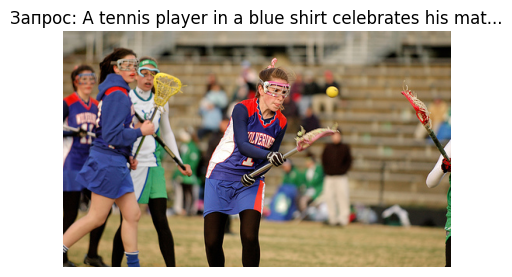


Запрос: 'A little kid holds up a remote control in front of the television .'
This image is unavailable in your country in compliance with local laws

Запрос: 'These girls are in uniforms and are playing field hockey .'
This image is unavailable in your country in compliance with local laws

Запрос: 'A spotted dog stands on his hind legs to catch a ball on the beach .'
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/tmp/ipython-input-47-536307149.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if pd.Series([query_text]).str.lower().str.contains(pattern, regex=True, na=False).any():


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Найденное изображение: 3514297698_0512623955.jpg


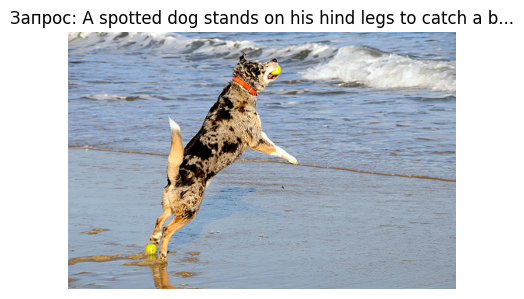


Запрос: 'A boy and a girl at the beach , throwing sand .'
This image is unavailable in your country in compliance with local laws

Запрос: 'a tan dog jumping through the field with some barren trees in the background'
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/tmp/ipython-input-47-536307149.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if pd.Series([query_text]).str.lower().str.contains(pattern, regex=True, na=False).any():


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Найденное изображение: 3514297698_0512623955.jpg


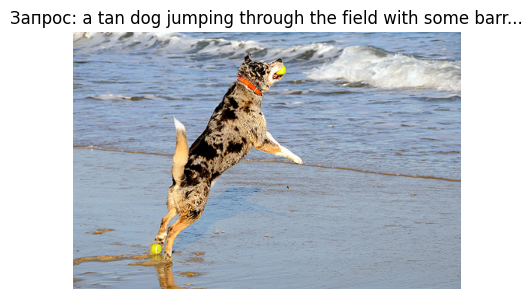


Запрос: 'There is an older white haired lady and a bulldog sitting on a tree stump .'
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/tmp/ipython-input-47-536307149.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if pd.Series([query_text]).str.lower().str.contains(pattern, regex=True, na=False).any():


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Найденное изображение: 3466891862_9afde75568.jpg


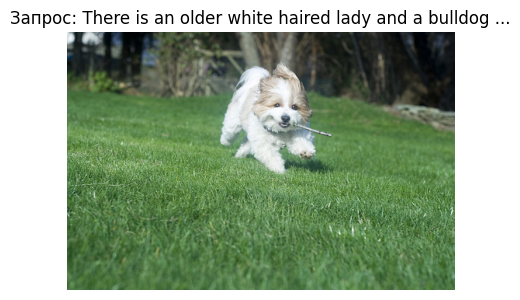


Запрос: 'A woman and a younger girl , both wearing blue jackets and knit caps , slide down a hill on a snow sled , a dog running at their side .'
This image is unavailable in your country in compliance with local laws

Запрос: 'A dog jumping for a tennis ball near an ocean'
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/tmp/ipython-input-47-536307149.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if pd.Series([query_text]).str.lower().str.contains(pattern, regex=True, na=False).any():


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Найденное изображение: 3514297698_0512623955.jpg


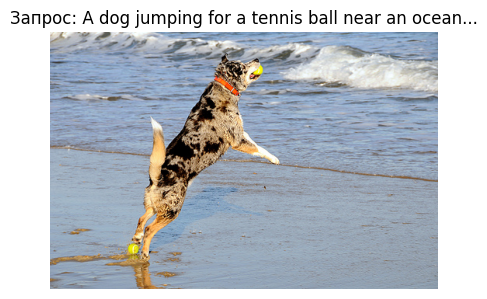


Запрос: 'a kickboxer jumping for a kick'
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/tmp/ipython-input-47-536307149.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if pd.Series([query_text]).str.lower().str.contains(pattern, regex=True, na=False).any():


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Найденное изображение: 123997871_6a9ca987b1.jpg


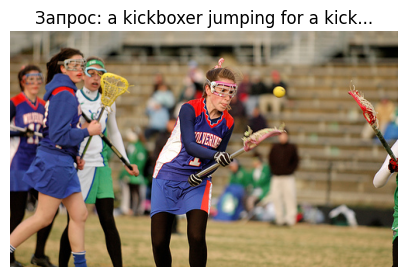

In [ ]:
# Векторизация текстовых запросов из test_queries
test_queries_texts = test_queries['query_text'].unique()

# Векторизация всех уникальных текстовых запросов
test_text_vectors = {}
for text in test_queries_texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model_text(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    test_text_vectors[text] = embedding

# Функция для поиска наиболее релевантного изображения по текстовому запросу
def find_relevant_image(query_text, model=dnn_model, scaler=scaler,
                        image_vectors=vectors_array_test, image_names=image_names_test,
                        legal_check=True):
    # Проверка на запрещенный контент
    if legal_check:
        pattern = r'\b(' + '|'.join(filter_words) + r')\b'
        if pd.Series([query_text]).str.lower().str.contains(pattern, regex=True, na=False).any():
            return "This image is unavailable in your country in compliance with local laws"

    # Векторизация текста
    inputs = tokenizer(query_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model_text(**inputs)
    text_vec = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    # Создаем комбинированные признаки для всех изображений
    combined_features = []
    for img_vec in image_vectors:
        combined_features.append(np.concatenate([img_vec, text_vec]))

    X_test = scaler.transform(np.vstack(combined_features))

    # Предсказание релевантности
    predictions = model.predict(X_test).flatten()

    # Находим индекс изображения с максимальной релевантностью
    best_idx = np.argmax(predictions)
    return image_names[best_idx]

# Тестирование на 10 случайных запросах
random.seed(RANDOM_STATE)
sample_queries = random.sample(list(test_queries_texts), 10)

# Вывод результатов для случайных запросов
for query in sample_queries:
    print(f"\nЗапрос: '{query}'")
    result = find_relevant_image(query)

    if result.startswith("This image"):
        print(result)
    else:
        print(f"Найденное изображение: {result}")
        try:
            img_path = os.path.join(test_image_dir, result)
            img = Image.open(img_path)
            plt.figure(figsize=(5,5))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Запрос: {query[:50]}...")
            plt.show()
        except:
            print("Ошибка загрузки изображения")

### Вывод

Cоздана функция, возвращающая 10 наиболее подходящих под описание фотографий. При проверке на тестовых данных модель показала низкое качество: изображения не совпадают с описаниями.

## 8. Общие выводы

В рамках проекта стояла задача разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе покажет, насколько текст и картинка подходят друг другу.

**В проекте реализованы следующие шаги:**

1. Данные загружены
2. В датасетах нет пропусков и дубликатов.
3. `train_dataset`
  - Размер: 5822 записей.
  - Колонки:
    - `image` — имя файла изображения (1000 уникальных).
    - `query_id` — идентификатор текстового описания, формат похож на `<image_name>#<индекс>`, всего 977 уникальных.
    - `query_text` — текст описания, всего 977 уникальных значений.
  - Нет пропусков и явных дубликатов.
  - Самый частый image встречается 10 раз.
  - Самый частый query_id встречается 34 раза.
  - Самый частый текст query_text встречается 34 раза.

  `test_queries`
  - В датасете 500 записей.
  - Каждая запись содержит:
    - `query_id` — уникальный идентификатор в формате "название_файла.jpg#число".
    - `query_text` — текст запроса/описания изображения.
    - `image` — имя файла с изображением.
  - `query_id` содержит 500 уникальных значений (все уникальны).
  - `query_text` — также 500 уникальных текстов (т.е. повторяющихся описаний нет).
  - `image` — всего 100 уникальных изображений, каждое изображение встречается в среднем 5 раз (т.к. всего 500 записей и 100 уникальных изображений).
  - Явных дубликатов и пропусков в данных нет.
  На одно изображение приходится по нескольку разных текстовых описаний.

  `test_images`
  - Таблица с одной колонкой `image`.
  - Всего 100 строк.
  - Все значения в колонке `image` непустые.
  - Уникальных значений в `image` — ровно 100, то есть все записи уникальны.
  - Явных дубликатов нет, пропусков тоже нет.
  - Максимальная частота любого значения — 1 (каждое изображение встречается только один раз).

  `crowd_annotations`
  - Таблица 47,830 строк и 5 колонок:
  - Отсутствие пропущенных значений
  - Дубликатов нет
  - `rate_confirmed`: среднее около 0.07, а медиана, 25 и 75 процентили равны 0 — значит большинство записей имеют rate_confirmed = 0. Максимум 1.0 показывает, что некоторые пары явно подтверждены, но их меньшинство.
  - `count_confirmed` также в основном 0 — очень мало подтверждений.
  - `count_not_confirmed` в основном 3, что скорее всего — минимальное число «отрицательных» голосов или проверок.
  - 41,970 записей (87.7%) имеют `rate_confirmed` = 0.0, что означает полное отсутствие подтверждения соответствия между изображением и текстовым описанием. Только 1,323 записи (2.8%) имеют `rate_confirmed` = 1.0 (полное подтверждение).Частичные подтверждения составляют менее 10% данных.
  - Количество уникальных изображений в crowd_annotations: 1000
  - Количество уникальных описаний в crowd_annotations: 1000
  - Количество уникальных изображений в crowd_annotations с rate_confirmed=1: 713
  - Количество изображений в crowd_annotations, совпадающих с их описанием: 721

  `expert_annotations`
  - В таблице 5822 записи с 5 колонками
  - Пропусков в данных не обнаружено
  - Явных дубликатов нет
  - exp_3 в среднем ставит более высокие оценки (mean=1.88)
  - exp_1 самый строгий (mean=1.44)
  - Все эксперты чаще ставят 1 или 2, чем 3 или 4
  - Большинство описаний получают низкие оценки
  - Лишь немногие достигают оценки 3-4, возможная причина: плохое качество исходных описаний
  - Количество уникальных изображений в expert_annotations: 1000
  - Количество уникальных описаний в expert_annotations: 977
  - Количество изображений с максимальной оценкой всех экспертов: 247
  - Количество уникальных изображений с максимальной оценкой всех экспертов: 214
  - Количество изображений в expert_annotations, совпадающих с их описанием: 158
4. Для построения модели выбрали только оценки экспертов, т.к. в `crowd_annotations` из 1323 записей с `rate_confirmed` = 1.0 только 713 изображений являются уникальными и 721 изображений совпадают с их описанием. Выполнили агрегацию оценок от трех экспертов в единый рейтинг

- Создан список, содержащий связанные с детьми слова
- Удалены изображения, описания которых попали под блокировку
- Количество записей в `train_dataset` после удаления запрещенных: 4207
- Количество уникальных изображений после удаления запрещенных: 736

- Выполнена векторизация изображений
- Обработано 736 изображений.
- Форма массива векторов: (736, 2048)

- Выполнена векторизация текстов
- Обработано 948 текстов
- Форма матрицы всех эмбеддингов: (948, 768)

- Векторы успешно объеденены, таргет и признаки разделены.
- Форма итогового массива признаков: (4207, 2816)
- Форма массива меток: (4207,)

- Обучены модели `Linear Regression`,	`Dummy Regressor`, `LightGBM Regressor`,	`Deep Neural Network`
- Лучший результат показала модель Deep Neural Network, её RMSE составил 0.233515. Данную модель быдем использовать на тестовой выборке.

- В рамках тестирования создана функция, возвращающая 10 наиболее подходящих под описание фотографий. При проверке на тестовых данных модель показала низкое качество: изображения не совпадают с описаниями.